In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-23 12:36:45.727907: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 12:36:45.757704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 12:36:46.215407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/RJ_Reconstrucao_Crustaceos_2024_06_25.xlsx')

df_TOTAL_CRUSTACEOS_M_e_Camarao = pd.DataFrame(df[['Ano','Camarao_art','Camarao_ind','Camarao_art_ind','TOTAL_CRUSTACEOS_M']])

#Juntando valores de art e ind em art_ind(quando os 2 estão presentes) 
for i in range(len(df_TOTAL_CRUSTACEOS_M_e_Camarao['Ano'])):
  if pd.isnull(df_TOTAL_CRUSTACEOS_M_e_Camarao.iloc[i,3])==True and pd.isnull(df_TOTAL_CRUSTACEOS_M_e_Camarao.iloc[i,2])==False and pd.isnull(df_TOTAL_CRUSTACEOS_M_e_Camarao.iloc[i,1])==False:
    df_TOTAL_CRUSTACEOS_M_e_Camarao.iloc[i,3] = df_TOTAL_CRUSTACEOS_M_e_Camarao.iloc[i,2] + df_TOTAL_CRUSTACEOS_M_e_Camarao.iloc[i,1] 

dados = df_TOTAL_CRUSTACEOS_M_e_Camarao[['Ano','Camarao_art_ind','TOTAL_CRUSTACEOS_M']].dropna().reset_index(drop=True)


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1965,1974])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Camarao'] = dados.loc[i,'Camarao_art_ind'] / dados.loc[i,'TOTAL_CRUSTACEOS_M']



prop = dados['Prop_Camarao'].values
dados.head()

,Ano,Camarao_art_ind,TOTAL_CRUSTACEOS_M,Prop_Camarao
0,1962,1555.0,1812.0,0.858168
1,1963,1597.0,2055.0,0.777129
2,1964,1928.0,2230.0,0.864574
3,1966,2268.0,2482.0,0.913779
4,1967,3472.0,3814.0,0.910330


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=500, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/pesos prop camarao_art_ind/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/pesos prop camarao_art_ind/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[0.79658103]
 [0.79898924]
 [0.80168617]
 [0.8043773 ]
 [0.8071996 ]
 [0.8100799 ]
 [0.81296015]
 [0.8159165 ]
 [0.81853545]
 [0.8210304 ]
 [0.82404304]
 [0.8273703 ]
 [0.8807025 ]
 [1.        ]]


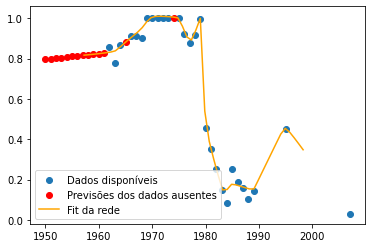

In [7]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

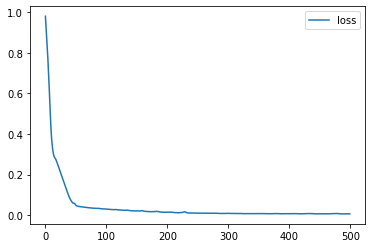

In [12]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [9]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1

#Trazendo valores previstos para TOTAL_CRUSTACEOS_M
df_prev_M = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Totais/Previsão TOTAL_CRUSTACEOS_M_1950-1974.xlsx')


for i in range(len(df_prev_M['Ano'])):
    if pd.isnull(df.loc[i,'TOTAL_CRUSTACEOS_M'])==True:
       df.loc[i,'TOTAL_CRUSTACEOS_M'] = df_prev_M.loc[i,'TOTAL_CRUSTACEOS_M']


df_preenchido = df[['Ano','Camarao_art_ind']]
for i in range(len(prev_continua)):
    if pd.isnull(df.loc[i,'Camarao_art_ind'])==True:
      df_preenchido.loc[i,'Camarao_art_ind']=df.loc[i,'TOTAL_CRUSTACEOS_M']*prev_continua[i]

df_preenchido = df_preenchido.loc[:1974-1950,:]
with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/Previsão Camarao_art_ind_1950-1974.xlsx')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     Ano  Camarao_art_ind
0   1950      1597.115234
1   1951      1517.034424
2   1952      1435.554077
3   1953      1287.010010
4   1954      1159.637939
5   1955      1402.511719
6   1956      1040.922485
7   1957       781.917480
8   1958      1015.011108
9   1959      1615.329224
10  1960       979.605896
11  1961       739.330261
12  1962      1555.000000
13  1963      1597.000000
14  1964      1928.000000
15  1965      2193.593262
16  1966      2268.000000
17  1967      3472.000000
18  1968      5875.000000
19  1969      3766.000000
20  1970      5715.000000
21  1971      4936.000000
22  1972      6144.000000
23  1973      9736.000000
24  1974      2380.260986


In [19]:
#TOTAL_CRUSTACEOS_M sem o que já foi para Camarao_art_ind
TOTAL_CRUSTACEOS_M_sem_Camarao = df[['Ano','TOTAL_CRUSTACEOS_M']]
for i in range(len(prev_continua)) :
    TOTAL_CRUSTACEOS_M_sem_Camarao.loc[i,'TOTAL_CRUSTACEOS_M'] -= df.loc[i,'TOTAL_CRUSTACEOS_M']*prev_continua[i]

with pd.option_context('display.max_rows', None,):
   print(TOTAL_CRUSTACEOS_M_sem_Camarao)

TOTAL_CRUSTACEOS_M_sem_Camarao.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/Previsão TOTAL_CRUSTACEOS_M_sem_Camarao.xlsx')

     Ano  TOTAL_CRUSTACEOS_M
0   1950          407.847412
1   1951          381.657593
2   1952          355.114258
3   1953          312.997803
4   1954          276.980713
5   1955          328.813477
6   1956          239.487793
7   1957          176.412781
8   1958          225.022095
9   1959          352.112305
10  1960          209.174133
11  1961          154.260315
12  1962          305.926514
13  1963          336.009766
14  1964          318.039551
15  1965          297.137939
16  1966          240.658203
17  1967          286.782715
18  1968          333.218750
19  1969           64.436279
20  1970            0.000000
21  1971            0.000000
22  1972            0.000000
23  1973            0.000000
24  1974            0.000000
25  1975         8185.000000
26  1976         3543.000000
27  1977         9064.000000
28  1978        24835.000000
29  1979        21827.000000
30  1980         3519.000000
31  1981         3190.500000
32  1982         3704.000000
33  1983      